In [1]:
!pip install --upgrade torch torchviz

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.5.1+cu101)
     |████████████████████████████████| 51kB 3.3MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3523 sha256=7f4880b4ffabe7a9e07fe71585b1cfdac2695fb00c46c6331e803f07370b144a
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


In [2]:
import torch
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device2 = torch.device('cpu')
print(device)
print(device2)

cuda
cpu


In [3]:
!nvidia-smi

Fri Jul  3 08:27:22 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    27W / 149W |     11MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 1, 28, 28).astype('float32')
x_test = x_test.reshape(10000, 1, 28, 28).astype('float32')

x_train/=255

BATCH_SIZE = 100

11493376/11490434 [==============================] - 0s 0us/step


In [5]:
from torch.utils.data import TensorDataset, DataLoader
tx_train = torch.from_numpy(x_train).float()
dataset_train = TensorDataset(tx_train)
loader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)

In [16]:
activation1 = torch.nn.Sigmoid()
activation2 = torch.nn.ReLU()
activation3 = torch.nn.Tanh()

nz = 100
layer_hidden1 = 7 * 7 * 256
filter1 = 256
filter2 = 128
filter3 = 32

class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.layer1 = nn.Linear(100, layer_hidden1)
    #self.bn1 = nn.BatchNorm1d(1)
    self.conv1 = nn.ConvTranspose2d(filter1, filter2, 2, 2)
    self.bn2 = nn.BatchNorm2d(filter2)
    self.conv2 = nn.ConvTranspose2d(filter2, filter3, 2, 2)
    self.bn3 = nn.BatchNorm2d(filter3)
    self.conv3 = nn.ConvTranspose2d(filter3, 1, 3, padding=1)

#activation 変える余地あり
  def forward(self, x):
    #x = activation2(self.bn1(self.layer1(x)))
    x = activation2(self.layer1(x))
    x = x.view(-1, 256, 7, 7)
    x = activation3(self.bn2(self.conv1(x)))
    x = activation3(self.bn3(self.conv2(x)))
    x = activation1(self.conv3(x))
    return x
g_model = Generator().to(device)
g_model

Generator(
  (layer1): Linear(in_features=100, out_features=12544, bias=True)
  (conv1): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2d(128, 32, kernel_size=(2, 2), stride=(2, 2))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

torch.Size([100, 1, 100])
torch.Size([1, 28, 28])
(100, 1, 28, 28)


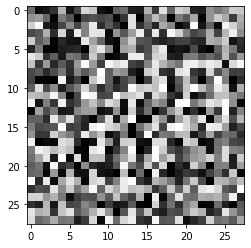

In [17]:
import matplotlib.pyplot as plt

def sample_z(batch_size):
  z = torch.rand(BATCH_SIZE, 1, 100)
  z = z.cuda()
  return z

xx = sample_z(BATCH_SIZE)
print(xx.shape)
yy = g_model(xx)
print(yy[1].shape)
yy2 = yy.to(device2)
yy2 = yy2.detach().clone().numpy()
print(yy2.shape)
plt.imshow(yy2[1].reshape(28,28), cmap='gray_r')

In [18]:
import torch.nn.functional as F
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.conv1 = nn.Conv2d(1, 16, 4, 2, padding=1)
    self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
    self.dropout1 = nn.Dropout(0.25)
    self.dropout2 = nn.Dropout(0.5)

    self.layer1 = nn.Linear(32*7*7, 16)
    self.layer2 = nn.Linear(16, 1)

  def forward(self, x):
    x = activation2(self.conv1(x))
    x = activation2(self.conv2(x))
    x = F.max_pool2d(x, (2, 2))
    x = self.dropout1(x)

    x = x.view(-1, 32*7*7)
    x = activation2(self.layer1(x))
    x = self.dropout2(x)
    x = activation1(self.layer2(x))
    return x

d_model = Discriminator().to(device)
d_model

Discriminator(
  (conv1): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (layer1): Linear(in_features=1568, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=1, bias=True)
)

In [19]:
yyy = d_model(yy)
yyy2 = yyy.to(device2)
print(yyy2[0])

tensor([0.5458], grad_fn=<SelectBackward>)


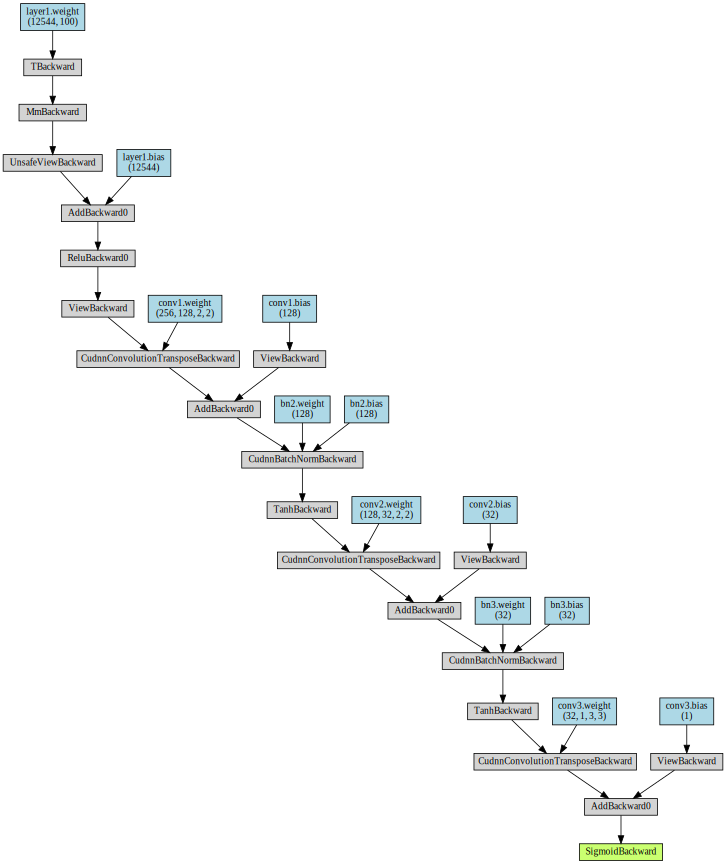

In [20]:
from torchviz import make_dot
make_dot(yy, params=dict(g_model.named_parameters()))

In [21]:
criterion = nn.BCELoss()
import torch.optim as optim
lr = 0.0005
g_optimizer = optim.Adam(g_model.parameters(), lr=lr)
d_optimizer = optim.Adam(d_model.parameters(), lr=lr)

In [22]:
ones = torch.ones(BATCH_SIZE)
zeros = torch.zeros(BATCH_SIZE)
ones = ones.to(device)
zeros = zeros.to(device)

def g_train():
  g_model.train()
  fake_image = g_model(sample_z(BATCH_SIZE))
  output = d_model(fake_image)
  g_loss = criterion(output, ones)
  g_loss.backward()
  g_optimizer.step()

  with torch.no_grad():
    g_output = g_model(sample_z(2))
    g_output = g_output.to(device2)
    g_output = g_output.detach().clone().numpy()
  
  return g_loss.item(), g_output

def d_train():
  d_model.train()
  data = np.arange(60000)
  np.random.shuffle(data)
  new_x_train = x_train[data]
  new_x_train = torch.from_numpy(new_x_train).float()
  new_x_trainb = new_x_train[:BATCH_SIZE]
  new_x_trainb = new_x_trainb.to(device)
  real_output = d_model(new_x_trainb)
  fake_image = g_model(sample_z(BATCH_SIZE))
  fake_output = d_model(fake_image)
  d_loss_real = criterion(real_output, ones)
  d_loss_fake = criterion(fake_output, zeros)
  d_loss = d_loss_real + d_loss_fake
  d_loss.backward()
  d_optimizer.step()

  return d_loss.item()

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:516: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[Epoch   1/100] g_loss: 0.60941, d_loss: 1.47270
[Epoch   2/100] g_loss: 0.57993, d_loss: 1.44845
[Epoch   3/100] g_loss: 0.57354, d_loss: 1.42915
[Epoch   4/100] g_loss: 0.56003, d_loss: 1.42521
[Epoch   5/100] g_loss: 0.55541, d_loss: 1.39311
[Epoch   6/100] g_loss: 0.54769, d_loss: 1.34555
[Epoch   7/100] g_loss: 0.54813, d_loss: 1.33632
[Epoch   8/100] g_loss: 0.54526, d_loss: 1.32780
[Epoch   9/100] g_loss: 0.52605, d_loss: 1.32247
[Epoch  10/100] g_loss: 0.51368, d_loss: 1.32252
[Epoch  11/100] g_loss: 0.50311, d_loss: 1.28042
[Epoch  12/100] g_loss: 0.50275, d_loss: 1.26325
[Epoch  13/100] g_loss: 0.51106, d_loss: 1.24967
[Epoch  14/100] g_loss: 0.50998, d_loss: 1.22575
[Epoch  15/100] g_loss: 0.51233, d_loss: 1.16846
[Epoch  16/100] g_loss: 0.52919, d_loss: 1.13386
[Epoch  17/100] g_loss: 0.53840, d_loss: 1.07951
[Epoch  18/100] g_loss: 0.56985, d_loss: 1.03181
[Epoch  19/100] g_loss: 0.58701, d_loss: 0.98312
[Epoch  20/100] g_loss: 0.61370, d_loss: 0.95265
[Epoch  21/100] g_lo

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


[Epoch  22/100] g_loss: 0.66107, d_loss: 0.84774
[Epoch  23/100] g_loss: 0.68442, d_loss: 0.81315
[Epoch  24/100] g_loss: 0.69433, d_loss: 0.79631
[Epoch  25/100] g_loss: 0.69929, d_loss: 0.77928
[Epoch  26/100] g_loss: 0.74012, d_loss: 0.73564
[Epoch  27/100] g_loss: 0.73189, d_loss: 0.70374
[Epoch  28/100] g_loss: 0.74478, d_loss: 0.71998
[Epoch  29/100] g_loss: 0.74185, d_loss: 0.69731
[Epoch  30/100] g_loss: 0.73834, d_loss: 0.71206
[Epoch  31/100] g_loss: 0.72030, d_loss: 0.71747
[Epoch  32/100] g_loss: 0.69084, d_loss: 0.73638
[Epoch  33/100] g_loss: 0.69361, d_loss: 0.79264
[Epoch  34/100] g_loss: 0.63355, d_loss: 0.79178
[Epoch  35/100] g_loss: 0.64582, d_loss: 0.87803
[Epoch  36/100] g_loss: 0.59203, d_loss: 0.93087
[Epoch  37/100] g_loss: 0.55336, d_loss: 0.98493
[Epoch  38/100] g_loss: 0.56537, d_loss: 0.92462
[Epoch  39/100] g_loss: 0.55322, d_loss: 0.91266
[Epoch  40/100] g_loss: 0.58863, d_loss: 0.80034
[Epoch  41/100] g_loss: 0.65492, d_loss: 0.77077
[Epoch  42/100] g_lo

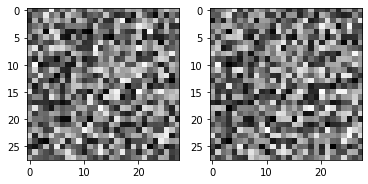

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

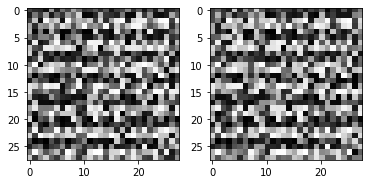

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

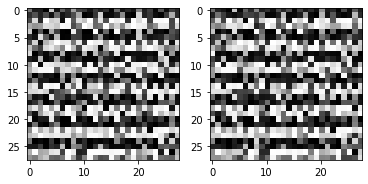

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

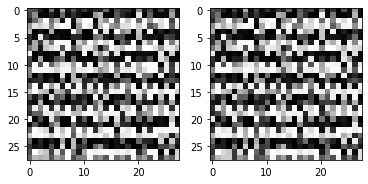

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

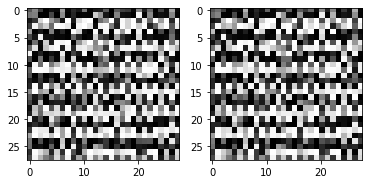

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

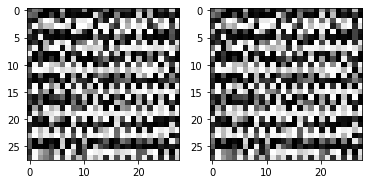

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

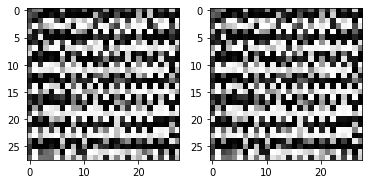

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

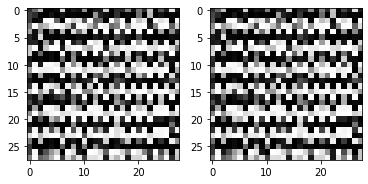

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

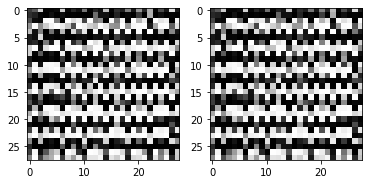

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

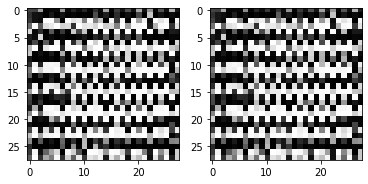

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

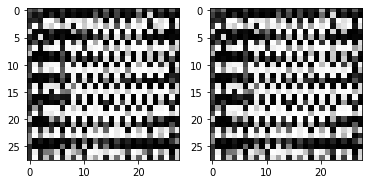

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

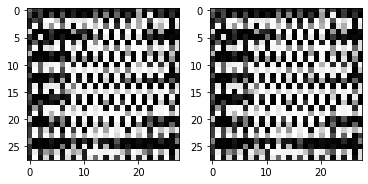

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

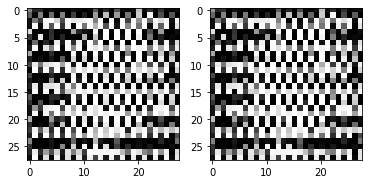

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

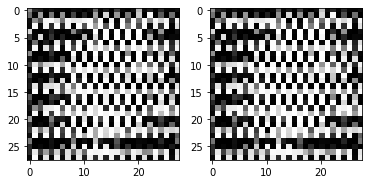

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

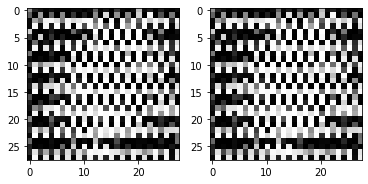

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

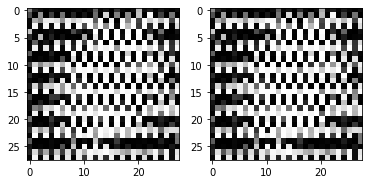

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

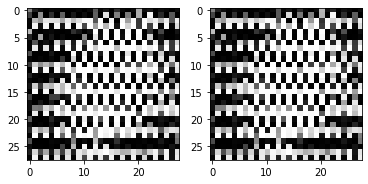

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

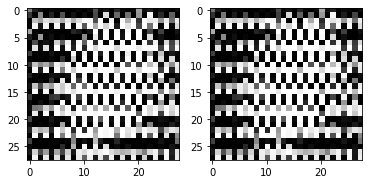

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

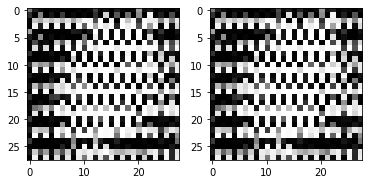

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

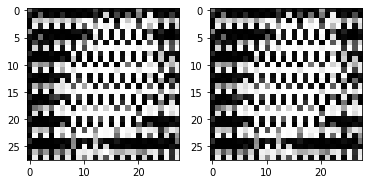

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [23]:
import numpy as np
import torch.nn.init as init

def init_parameters(self):
  for m in self.modules():
    if isinstance(m, nn.Conv2d):
      init.xavier_uniform_(m.weight.data, gain=init.calculate_gain('relu'))

def init_parameters1(self):
  for m in self.modules():
    if isinstance(m, nn.ConvTranspose2d):
      init.xavier_uniform_(m.weight.data, gain=init.calculate_gain('relu'))

g_model.apply(init_parameters1)
g_model.apply(init_parameters)
d_model.apply(init_parameters)

epochs = 100

g_loss = []
d_loss = []

for epoch in range(epochs):
  gene_loss = 0.0
  fake_images = torch.empty(BATCH_SIZE, 28, 28)
  gene_loss, fake_images = g_train()
  
  disc_loss = d_train()
  g_loss.append(gene_loss)
  d_loss.append(disc_loss)
  
  print(f'[Epoch {epoch+1:3d}/{epochs:3d}]' \
          f' g_loss: {gene_loss:.5f}, d_loss: {disc_loss:.5f}')

  fig = plt.figure()
  if epoch % 5 == 0:
    for i in range(2):
      a = fig.add_subplot(1,2,i+1)
      a.imshow(fake_images[i].reshape(28,28),cmap='gray_r')

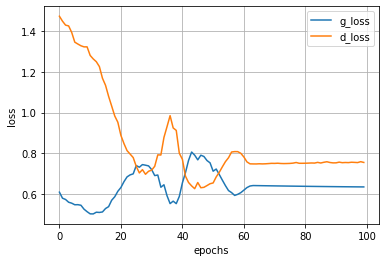

In [24]:
plt.plot(range(epochs), g_loss, marker=' ', label='g_loss')
plt.plot(range(epochs), d_loss, marker=' ', label='d_loss')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

結果発表〜〜〜〜〜〜！！！
(100, 1, 28, 28)
本物↓


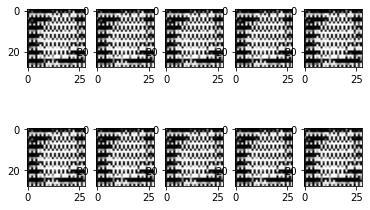

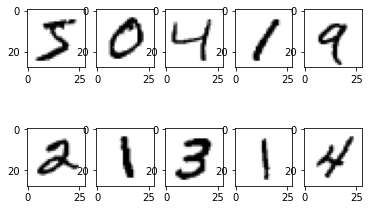

In [25]:
z = sample_z(BATCH_SIZE)
yy = g_model(z)
print("結果発表〜〜〜〜〜〜！！！")
yy = yy.to(device2)
yy2 = yy.detach().clone().numpy()
print(yy2.shape)
import matplotlib.pyplot as plt
figg = plt.figure()
for i in range(10):
  a = figg.add_subplot(2,5,i+1)
  a.imshow(yy2[i].reshape(28,28),cmap='gray_r')
print("本物↓")
figgg = plt.figure()
for i in range(10):
  a = figgg.add_subplot(2,5,i+1)
  a.imshow(x_train[i].reshape(28,28),cmap='gray_r')

In [ ]:
activation = nn.Sigmoid()
h = torch.rand(1, 1, 512)
em = nn.Embedding(VOCAB_SIZE, 512)
s = torch.tensor([40477])
gru = nn.GRU(512, 512)
o = em(s)
o = o.view(1,1,512)
o, h = gru(o, h)
oo = o.view(1, 512)
out = nn.Linear(512, VOCAB_SIZE)
output  = activation(out(oo))
print(o.size())
print(h.size())
print(output.size())

In [ ]:
v = []
x = torch.rand(1, 4)
x = x.detach().clone().numpy()
y = np.argmax(x)
v.append(y)
v.append(y)
v